In [1]:
!pip install --quiet yfinance pandas numpy scipy matplotlib seaborn

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from scipy import stats
from math import sqrt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)





In [3]:
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'SPY']
END = datetime.today()
START = END - timedelta(days=365*5)  # ~5 лет

print(f"Downloading {len(TICKERS)} tickers from {START.date()} to {END.date()}")

In [4]:
#  загрузка цен через yfinance
data = yf.download(TICKERS,
                   start=START.strftime('%Y-%m-%d'),
                   end=END.strftime('%Y-%m-%d'),
                   progress=False,
                   auto_adjust=True)


if isinstance(data.columns, pd.MultiIndex):
    # Попробуем получить 'Adj Close' или 'Close' если есть
    lvl0 = list(data.columns.get_level_values(0))
    lvl1 = list(data.columns.get_level_values(1))
    if 'Adj Close' in lvl0:
        prices = data['Adj Close']
    elif 'Close' in lvl0:
        prices = data['Close']
    elif 'Adj Close' in lvl1:
        prices = data.xs('Adj Close', axis=1, level=1)
    elif 'Close' in lvl1:
        prices = data.xs('Close', axis=1, level=1)
    else:
        # fallback: попробуем "свернуть" и оставить числовые колонки
        prices = data.copy()
else:
    prices = data.copy()

available = [c for c in prices.columns if c in TICKERS]

prices = prices[available].sort_index(axis=1)
prices = prices.dropna(how='all')

print("Final prices shape:", prices.shape)
display(prices.head())

Final prices shape: (1255, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,SPY
Date,,,,,
2020-11-02,105.802521,150.223999,80.748917,193.999115,307.832458
2020-11-03,107.426949,152.420502,81.949692,197.930328,313.267548
2020-11-04,111.813904,162.057999,86.862076,207.480255,320.268860
2020-11-05,115.782585,166.100006,87.569244,214.096115,326.514984
2020-11-06,115.651054,165.568497,87.488792,214.508423,326.440369


In [8]:
prices.to_csv('data/prices.csv')
print("Saved: data/prices.csv — shape:", prices.shape)
prices.tail()

Saved: data/prices.csv — shape: (1255, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,SPY
Date,,,,,
2025-10-24,262.820007,224.210007,260.510010,523.609985,677.250000
2025-10-27,268.809998,226.970001,269.929993,531.520020,685.239990
2025-10-28,269.000000,229.250000,268.429993,542.070007,687.059998
2025-10-29,269.700012,230.300003,275.170013,541.549988,687.390015
2025-10-30,271.399994,222.860001,281.899994,525.760010,679.830017


In [9]:
# Log returns: r_t = ln(P_t / P_{t-1})
returns = np.log(prices / prices.shift(1)).dropna(how='all')
returns.to_csv('data/returns.csv')
returns.describe().T


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,1254.0,0.000751,0.017737,-0.097013,-0.008122,0.001148,0.010104,0.142617
AMZN,1254.0,0.000315,0.022018,-0.151398,-0.011009,0.000378,0.012383,0.126949
GOOG,1254.0,0.000997,0.019349,-0.101313,-0.009257,0.001842,0.011213,0.094994
MSFT,1254.0,0.000795,0.016250,-0.080295,-0.007387,0.000816,0.009932,0.096525
SPY,1254.0,0.000632,0.010791,-0.060327,-0.004439,0.000768,0.006319,0.099863


<Figure size 1000x500 with 0 Axes>

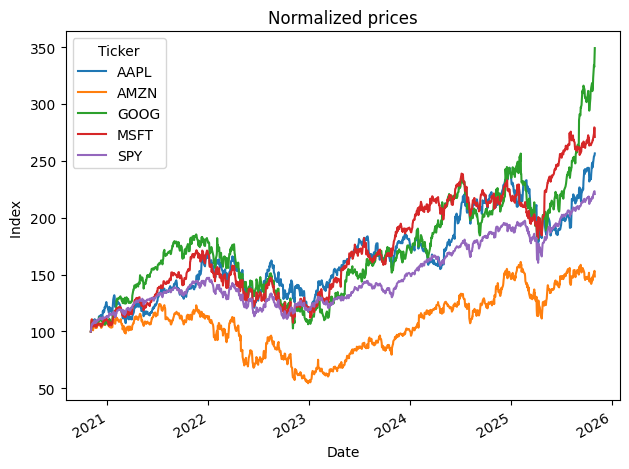

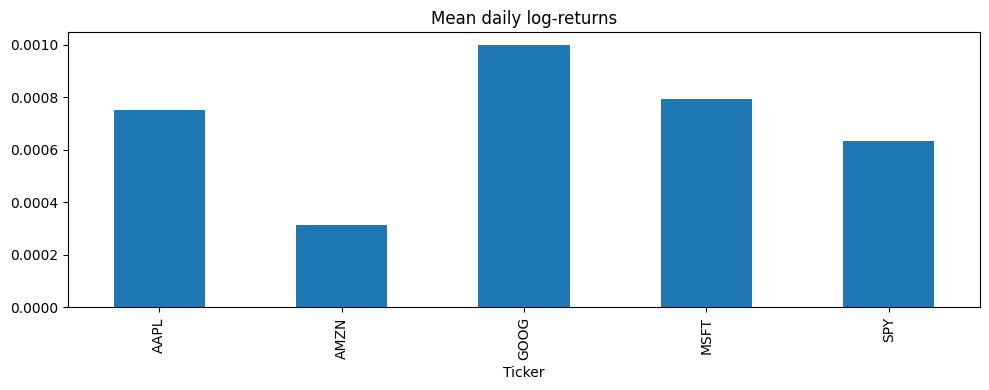

In [10]:
plt.figure(figsize=(10,5))
(100 * prices / prices.iloc[0]).plot(title='Normalized prices')
plt.ylabel('Index ')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
returns.mean().plot(kind='bar', title='Mean daily log-returns')
plt.tight_layout()
plt.show()


# 2 шаг - простые метрики

в портфеле будут одинковые веса для всех 5 акций

In [18]:
TRADING_DAYS = 252  # не трейдят по выходным
WEIGHTS = {'AAPL':0.2, 'MSFT':0.2, 'AMZN':0.2, 'GOOG':0.2, 'SPY':0.2}

In [19]:
prices = pd.read_csv('data/prices.csv', index_col=0, parse_dates=True)
weights = pd.Series(WEIGHTS)
tickers=list(prices.columns)

percent change и log котировок

In [20]:
simple_rets = prices.pct_change().dropna(how="all")
log_rets = returns

In [21]:
port_simple=(simple_rets*weights).sum(axis=1) # доходность простого портфеля
port_log=(log_rets*weights).sum(axis=1) # доходность log портфеля
port_d = pd.DataFrame({
    "simple_r": port_simple,
    "log_r": port_log
})

port_d.to_csv("data/portfolio_returns.csv")
port_d.shape

(1254, 2)

In [22]:
daily_mean=port_simple.mean()
daily_std = port_simple.std(ddof=1)
an_mean=daily_mean*TRADING_DAYS # годовой средний доход
an_std=daily_std* (TRADING_DAYS ** 0.5)
rf_annual = 0.03
sharpe = (an_mean - rf_annual) / an_std
sharpe

np.float64(0.79305728911463)

In [23]:
skew = stats.skew(port_simple.dropna())
kurt = stats.kurtosis(port_simple.dropna(), fisher=False)
print(skew)
print(kurt)

0.18877110856020338
7.647191187853094


Так как skew=0.18, kurt=7.6

Большинство доходностей — вокруг среднего,
но очень иногда случаются редкие большие прибыли

Доходности обычно спокойные  ,
но иногда случаются очень большие скачки( kurt в норме 3)— как положительные, так и отрицательные.
То есть стратегия подвержена «tail risk» — редким, но сильным событиям

In [24]:
#считаем максимальное падение с пика - Max drowdawn
cumret=(1+port_simple).cumprod()
running_max=cumret.cummax()
drawdown=(cumret-running_max)/running_max
max_drawdawn=drawdown.min()
max_drawdawn

-0.35184617548852204

максимальное падение на 35%

In [25]:
var_95=port_simple.quantile(0.05)
print(var_95)
var_99=port_simple.quantile(0.01)
print(var_99)

-0.023946639827853836
-0.0383481795109055


In [26]:
es_95=port_simple[port_simple<=var_95].mean()
es_99=port_simple[port_simple<=var_99].mean()
print(es_95)
print(es_99)

-0.032937023023816625
-0.0473331544281993


In [27]:
stats_dict = {
    'n_assets': 5,
    'tickers': tickers,
    'weights': weights.to_dict(),
    'daily_mean_return': float(daily_mean),
    'daily_volatility': float(daily_std),
    'annualized_mean_return': float(an_mean),
    'annualized_volatility': float(an_std),
    'sharpe_annual': float(sharpe),
    'skewness': float(skew),
    'kurtosis': float(kurt),
    'max_drawdown': float(max_drawdawn),
    'var_95_empirical': float(var_95),
    'var_99_empirical': float(var_99),
    'es_95_empirical': float(es_95),
    'es_99_empirical': float(es_99),
    'n_observations': int(port_simple.shape[0])
}

with open('results/portfolio_stats.json', 'w') as f:
    json.dump(stats_dict, f, indent=2, ensure_ascii=False)

print(f"Saved portfolio stats -> {'results/portfolio_stats.json'}")
print("\nKey stats:")
for k in ['annualized_mean_return','annualized_volatility','sharpe_annual','max_drawdown','var_95_empirical','var_99_empirical']:
    print(f"{k}: {stats_dict[k]}")




Saved portfolio stats -> results/portfolio_stats.json

Key stats:
annualized_mean_return: 0.2151134442337093
annualized_volatility: 0.23341749300403017
sharpe_annual: 0.79305728911463
max_drawdown: -0.35184617548852204
var_95_empirical: -0.023946639827853836
var_99_empirical: -0.0383481795109055


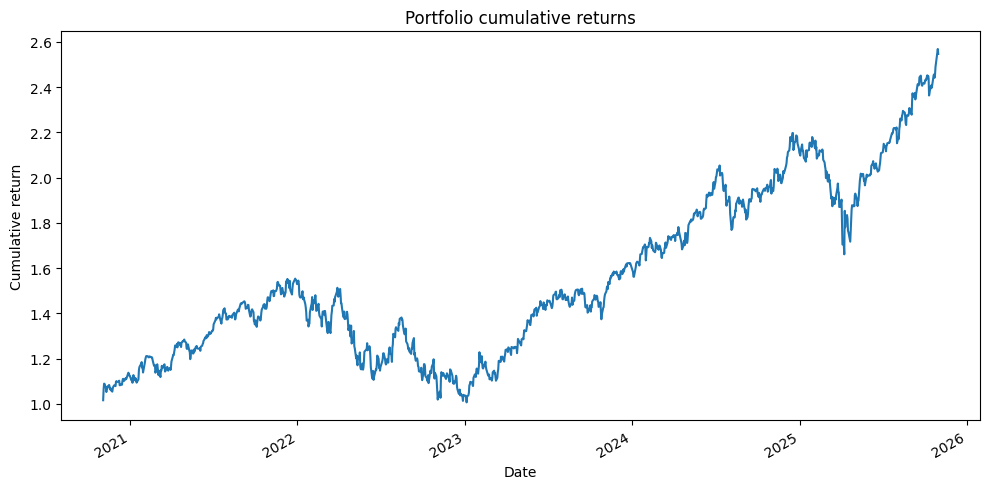

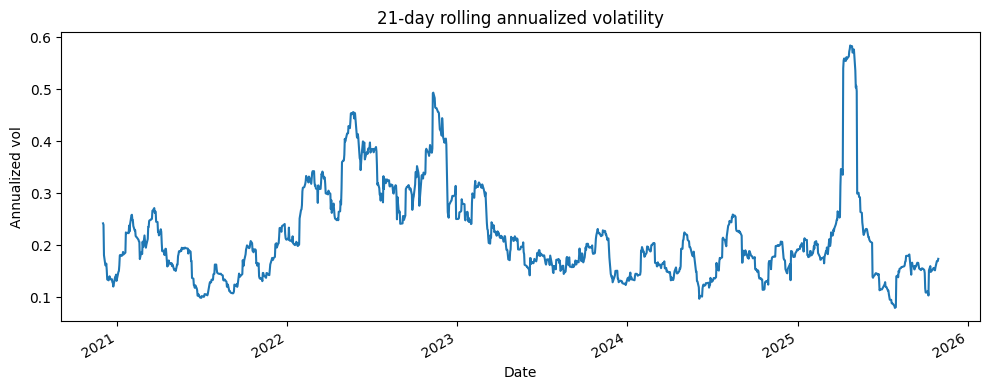

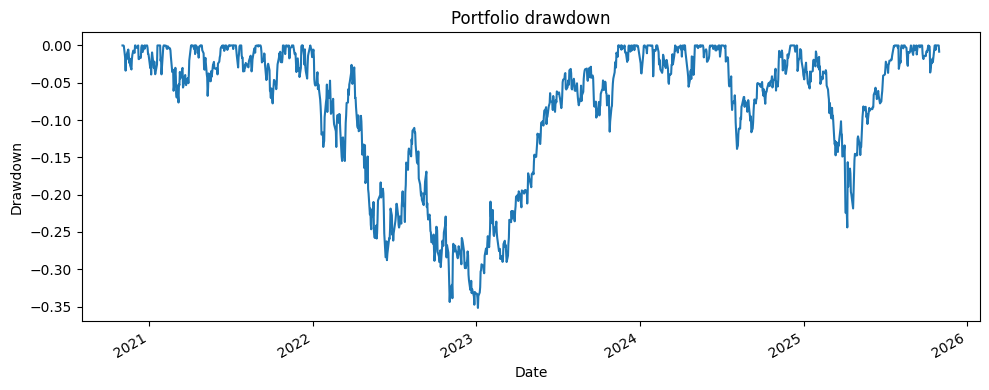

In [28]:

plt.figure(figsize=(10,5))
cumret.plot(title='Portfolio cumulative returns')
plt.ylabel('Cumulative return')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
(port_simple.rolling(window=21).std() * sqrt(TRADING_DAYS)).plot(title='21-day rolling annualized volatility')
plt.ylabel('Annualized vol')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
drawdown.plot(title='Portfolio drawdown')
plt.ylabel('Drawdown')
plt.tight_layout()
plt.show()

# Шаг 3
# VaR + rolling backtest

In [29]:
ALPHAS = [0.95, 0.99]  # уровни доверия
WINDOW = 252  # rolling window для оценки VaR (пример: 1 год торговых дней)
METHODS = ['historical', 'parametric_normal']  # методы


In [32]:
pf = pd.read_csv('data/portfolio_returns.csv', index_col=0, parse_dates=True)
returns = pf['simple_r'].dropna()
T = len(returns)

In [34]:
from scipy.stats import chi2
def historical_var(series, alpha):
    q = series.quantile(1 - alpha)
    return q

def parametric_norm_var(series, alpha):
    """Parametric VaR under normal assumption (mean, std)."""
    mu = series.mean()
    sigma = series.std(ddof=1)
    from scipy.stats import norm
    z = norm.ppf(1 - alpha)
    return mu + sigma * z
def kupiec_pof_test(n_exceptions, n_obs, alpha):
    p = 1 - alpha
    x = n_exceptions
    N = n_obs
    pi_hat = x / N
    if (pi_hat == 0) or (pi_hat == 1):
        # log(0):
        # If x==0 then L1 = (1)^N and L0 = (1-p)^N => LR = -2 * N * ln(1-p)
        if x == 0:
            LR = -2 * (N * np.log(1 - p))
        else:
            LR = -2 * (N * np.log(p))
        pvalue = 1 - chi2.cdf(LR, df=1)
        return LR, pvalue
    # general case
    term1 = x * np.log(p / pi_hat) if x > 0 else 0.0
    term2 = (N - x) * np.log((1 - p) / (1 - pi_hat)) if N - x > 0 else 0.0
    LR = -2 * (term1 + term2)
    pvalue = 1 - chi2.cdf(LR, df=1)
    return LR, pvalue


In [35]:
static_results = {}
for method in METHODS:
    static_results[method] = {}
    for alpha in ALPHAS:
        if method == 'historical':
            v = historical_var(returns, alpha)
        elif method == 'parametric_normal':
            v = parametric_norm_var(returns, alpha)
        static_results[method][alpha] = float(v)

print("Static VaR (full-sample):")
print(pd.DataFrame(static_results))

Static VaR (full-sample):
      historical  parametric_normal
0.95   -0.023947          -0.023332
0.99   -0.038348          -0.033353


In [39]:
#Rolling VaR backtest
idx=returns.index
rolling_stats={
    method:{ alpha:{'n_obs': 0, 'n_exceptions': 0, 'sum_shortfall': 0.0, 'exceptions_list': []}
            for alpha in ALPHAS}
    for method in METHODS


}

for i in range(WINDOW,T):
  window_series=returns.iloc[i-WINDOW:i]
  ret_t=returns.iloc[i] #смотрим на след. день
  for method in METHODS:
    for alpha in ALPHAS:
      if method == 'historical':
        var_t = historical_var(window_series, alpha)
      if method=="parametric_normal":
        var_t = parametric_norm_var(window_series, alpha)
      is_except= 1 if ret_t<var_t else 0
      s = rolling_stats[method][alpha]
      s['n_obs'] += 1
      s['n_exceptions'] += is_except
      if is_except:
        shortfall=ret_t-var_t
        s['sum_shortfall']+=shortfall
        s['exceptions_list'].append({'date': str(idx[i].date()), 'return': float(ret_t), 'var': float(var_t), 'shortfall': float(shortfall)})



In [40]:
# пост - статистика по rolling stats
for method in METHODS:
    for alpha in ALPHAS:
      s = rolling_stats[method][alpha]
      n_obs=s["n_obs"]
      x = s['n_exceptions']
      rate=x/n_obs if n_obs > 0 else np.nan
      avg_shortfall=s["sum_shortfall"]/x if x>0 else np.nan
      LR, pval = kupiec_pof_test(x, n_obs, alpha)
      s.update({'exception_rate': rate, 'avg_shortfall': avg_shortfall, 'kupiec_LR': LR, 'kupiec_pvalue': pval})

In [45]:
rows = []
for method in METHODS:
    for alpha in ALPHAS:
        s = rolling_stats[method][alpha]
        rows.append({
            'method': method,
            'alpha': alpha,
            'n_obs': s['n_obs'],
            'n_exceptions': s['n_exceptions'],
            'exception_rate': s['exception_rate'],
            'expected_rate': 1 - alpha,
            'avg_shortfall': s['avg_shortfall'],
            'kupiec_LR': s['kupiec_LR'],
            'kupiec_pvalue': s['kupiec_pvalue']
        })
res_df = pd.DataFrame(rows)
res_df = res_df.sort_values(['alpha', 'method'], ascending=[False, True]).reset_index(drop=True)
display(res_df)

,method,alpha,n_obs,n_exceptions,exception_rate,expected_rate,avg_shortfall,kupiec_LR,kupiec_pvalue
0,historical,0.99,1002,18,0.017964,0.01,-0.009448,5.192760,0.022681
1,parametric_normal,0.99,1002,27,0.026946,0.01,-0.009386,19.860028,0.000008
2,historical,0.95,1002,63,0.062874,0.05,-0.008960,3.243942,0.071688
3,parametric_normal,0.95,1002,67,0.066866,0.05,-0.010005,5.451830,0.019548


In [43]:
detailed = {'static_var': static_results, 'rolling_stats': rolling_stats}
with open('results/var_backtest_results.json', 'w') as f:
    json.dump(detailed, f, indent=2, ensure_ascii=False)

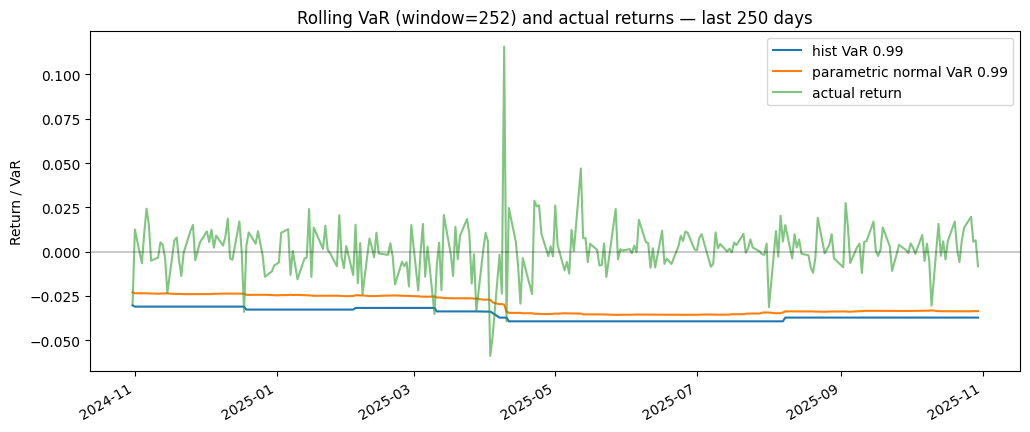

In [44]:
alpha_plot = 0.99
plt.figure(figsize=(12,5))
# Построим ряд rolling VaR по последним 100 дней оценок (оценка на день t для t+1)
dates = []
hist_var_series = []
norm_var_series = []
test_returns = []
for i in range(WINDOW, T):
    dates.append(returns.index[i])
    w = returns.iloc[i-WINDOW:i]
    hist_var_series.append(historical_var(w, alpha_plot))
    norm_var_series.append(parametric_norm_var(w, alpha_plot))
    test_returns.append(returns.iloc[i])

hist_var_s = pd.Series(hist_var_series, index=dates)
norm_var_s = pd.Series(norm_var_series, index=dates)
test_ret_s = pd.Series(test_returns, index=dates)

window_plot = 250
hist_var_s.tail(window_plot).plot(label=f'hist VaR {alpha_plot}')
norm_var_s.tail(window_plot).plot(label=f'parametric normal VaR {alpha_plot}')
test_ret_s.tail(window_plot).plot(secondary_y=False, label='actual return', alpha=0.6)
plt.legend()
plt.title(f'Rolling VaR (window={WINDOW}) and actual returns — last {min(window_plot, len(dates))} days')
plt.axhline(0, color='k', linewidth=0.3)
plt.ylabel('Return / VaR')
plt.show()


Исторический VaR лучше отражает хвосты (меньше нарушений), но и он может не выдержать строгого регуляторного бэктеста на уровне 99%

Для регуляторных целей parametric_normal — неприемлем на этих данных; historical — ближе, но на 99% тоже проблемный.

parametric_normal плохо: отвергается и на 99% и на 95%.
historical — лучше, но на 99% уровне тоже статистически проблемен (p≈0.0227). На 95% — приемлем (p≈0.07).

# Шаг 4
CVaR/ES

In [55]:
pf = pd.read_csv('data/portfolio_returns.csv', index_col=0, parse_dates=True)
simple_rets = pf['simple_r'].dropna()
dates = returns.index

In [56]:
def historical_es(series, alpha):
    q = historical_var(series, alpha)
    tail = series[series <= q]
    if len(tail) == 0:
        return np.nan
    return tail.mean()

def parametric_es(series, alpha):
    mu = series.mean()
    sigma = series.std(ddof=1)
    from scipy.stats import norm
    z = norm.ppf(1 - alpha)
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    if Phi == 0:
        return np.nan
    return mu - sigma * (phi / Phi)

In [57]:
static = []
for method in ['historical', 'parametric_normal']:
    for alpha in ALPHAS:
        if method == 'historical':
            v = historical_var(simple_rets, alpha)
            es = historical_es(simple_rets, alpha)
        else:
            v = parametric_norm_var(simple_rets, alpha)
            es = parametric_es(simple_rets, alpha)
        static.append({
            'method': method,
            'alpha': alpha,
            'mode': 'static_fullsample',
            'est_VaR': float(v),
            'est_ES': float(es) if not np.isnan(es) else None,
            'n_obs': int(T),
            'n_exceptions': int((simple_rets < v).sum()),
            'exception_rate': float((simple_rets < v).mean())
        })


In [58]:
#тот же rolling что и на 3-ем шаге
rolling_stats = []
for method in METHODS:
    for alpha in ALPHAS:
        n_obs = 0
        n_ex = 0
        sum_shortfall = 0.0
        realized_losses = []
        est_es_list = []
        est_var_list = []
        for i in range(WINDOW, T):
            window = simple_rets.iloc[i - WINDOW:i]
            ret_t =simple_rets.iloc[i]
            if method == 'historical':
                v = historical_var(window, alpha)
                es_est = historical_es(window, alpha)
            else:
                v = parametric_norm_var(window, alpha)
                es_est = parametric_es(window, alpha)
            n_obs += 1
            est_var_list.append(v)
            est_es_list.append(es_est)
            if ret_t < v:
                n_ex += 1
                shortfall = ret_t - v
                sum_shortfall += shortfall
                realized_losses.append(ret_t)
        exception_rate = n_ex / n_obs if n_obs > 0 else np.nan
        avg_shortfall = (sum_shortfall / n_ex) if n_ex > 0 else np.nan
        mean_est_es = np.nanmean(est_es_list) if len(est_es_list) > 0 else np.nan
        mean_est_var = np.nanmean(est_var_list) if len(est_var_list) > 0 else np.nan
        realized_es = np.nanmean(realized_losses) if len(realized_losses) > 0 else np.nan
        rolling_stats.append({
            'method': method,
            'alpha': alpha,
            'mode': f'rolling_window_{WINDOW}',
            'n_obs': int(n_obs),
            'n_exceptions': int(n_ex),
            'exception_rate': float(exception_rate),
            'avg_shortfall': float(avg_shortfall) if not np.isnan(avg_shortfall) else None,
            'mean_estimated_VaR': float(mean_est_var) if not np.isnan(mean_est_var) else None,
            'mean_estimated_ES': float(mean_est_es) if not np.isnan(mean_est_es) else None,
            'realized_ES_when_breached': float(realized_es) if not np.isnan(realized_es) else None
        })

In [59]:
summary = pd.DataFrame(static + rolling_stats)
summary['expected_rate'] = 1 - summary['alpha']
cols_order = ['method','alpha','mode','n_obs','n_exceptions','exception_rate','expected_rate',
              'est_VaR','est_ES','mean_estimated_VaR','mean_estimated_ES','realized_ES_when_breached','avg_shortfall']
for c in cols_order:
    if c not in summary.columns:
        summary[c] = None
summary = summary[cols_order]

os.makedirs('results', exist_ok=True)
summary.to_csv('results/var_es_comparison.csv', index=False)
with open('results/var_es_comparison.json', 'w') as f:
    json.dump(json.loads(summary.to_json(orient='records')), f, indent=2, ensure_ascii=False)

pd.set_option('display.float_format', lambda x: f'{x:.6f}' if pd.notnull(x) else 'NaN')
display(summary)

,method,alpha,mode,n_obs,n_exceptions,exception_rate,expected_rate,est_VaR,est_ES,mean_estimated_VaR,mean_estimated_ES,realized_ES_when_breached,avg_shortfall
0,historical,0.950000,static_fullsample,1254,63,0.050239,0.050000,-0.023947,-0.032937,NaN,NaN,NaN,NaN
1,historical,0.990000,static_fullsample,1254,13,0.010367,0.010000,-0.038348,-0.047333,NaN,NaN,NaN,NaN
2,parametric_normal,0.950000,static_fullsample,1254,72,0.057416,0.050000,-0.023332,-0.029476,NaN,NaN,NaN,NaN
3,parametric_normal,0.990000,static_fullsample,1254,25,0.019936,0.010000,-0.033353,-0.038335,NaN,NaN,NaN,NaN
4,historical,0.950000,rolling_window_252,1002,63,0.062874,0.050000,NaN,NaN,-0.024037,-0.031892,-0.031491,-0.008960
5,historical,0.990000,rolling_window_252,1002,18,0.017964,0.010000,NaN,NaN,-0.036106,-0.041949,-0.041071,-0.009448
6,parametric_normal,0.950000,rolling_window_252,1002,67,0.066866,0.050000,NaN,NaN,-0.023453,-0.029572,-0.030725,-0.010005
7,parametric_normal,0.990000,rolling_window_252,1002,27,0.026946,0.010000,NaN,NaN,-0.033433,-0.038395,-0.039191,-0.009386


Parametric normal последовательно менее консервативен относительно хвоста: на уровне 99% разница сильно заметна (parametric даёт гораздо меньше негативный ES и больше нарушений).

Historical лучше отражает хвосты — меньше нарушений и более консервативные ES.

# Шаг 5
EVT (Peaks Over Threshold, GPD)

In [53]:
from scipy.stats import genpareto
from scipy import stats
from math import isclose

In [70]:
THRESH_QUANTILE = 0.9
MIN_EXCEEDANCES = 10  # для паретто
losses = -simple_rets

In [71]:
def pick_threshold(series_losses, q=THRESH_QUANTILE):
    return series_losses.quantile(q)


def mean_residual_life_plot(series_losses, thresholds=None, ax=None):
    s = series_losses.dropna()
    if thresholds is None:
        thresholds = np.linspace(s.quantile(0.6), s.quantile(0.98), 20)
    means = []
    counts = []
    for u in thresholds:
        exc = s[s > u] - u
        means.append(exc.mean() if len(exc) > 0 else np.nan)
        counts.append(len(exc))
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(thresholds, means, marker='o')
    ax.set_xlabel('Threshold u (loss)')
    ax.set_ylabel('Mean excess over u')
    ax.set_title('Mean Residual Life (Mean Excess) Plot')
    return ax, thresholds, means, counts


def fit_gpd_excesses(series_losses, u):
    exc = series_losses[series_losses > u] - u
    exc = exc.dropna()
    n_exc = len(exc)
    c, loc, scale = genpareto.fit(exc, floc=0)
    xi = float(c)
    beta = float(scale)
    return xi, beta, n_exc

def evt_var_es_from_gpd(u, xi, beta, p_u, alpha):
    s = (1 - alpha) / p_u
    extrapolation = False
    if s > 1.0:
        extrapolation = True
    if abs(xi) < 1e-8:
        # xi -> 0 case: GPD -> Exponential
        z = -beta * np.log(s)
    else:
        z = (beta / xi) * (s**(-xi) - 1)
    q_loss = u + z
    if xi >= 1:
        es_loss = np.nan
    else:
        es_loss = q_loss + (beta + xi * (q_loss - u)) / (1 - xi)
    var_return = -q_loss
    es_return = -es_loss if not np.isnan(es_loss) else np.nan
    return {'q_loss': q_loss, 'var_return': var_return, 'es_return': es_return, 's': s, 'extrapolation': extrapolation}



In [72]:
n = len(losses)
u_full = pick_threshold(losses, THRESH_QUANTILE)
xi_full, beta_full, n_exc_full = fit_gpd_excesses(losses, u_full)
p_u_full = n_exc_full / n
print(f"Full-sample EVT: threshold u={u_full:.6f}, exceedances={n_exc_full}/{n} (p_u={p_u_full:.4f}), xi={xi_full:.4f}, beta={beta_full:.6f}")

Full-sample EVT: threshold u=0.017442, exceedances=126/1254 (p_u=0.1005), xi=-0.0578, beta=0.009881


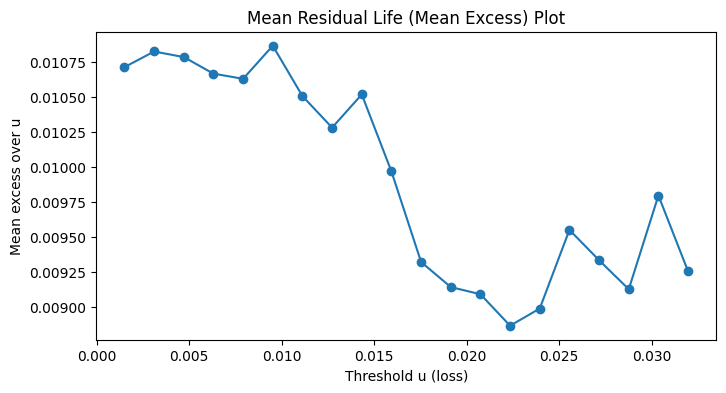

In [73]:
ax, thresholds, means, counts = mean_residual_life_plot(losses)
plt.show()

EVT static alpha=0.95: VaR_return=-0.024201, ES_return=-0.033172, extrapolation=False, s=0.4976
EVT static alpha=0.99: VaR_return=-0.038785, ES_return=-0.046959, extrapolation=False, s=0.0995


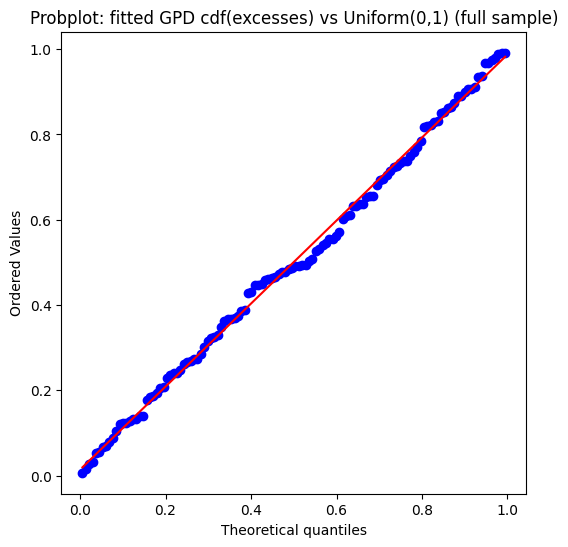

In [74]:
evt_static = {}
for alpha in ALPHAS:
  res = evt_var_es_from_gpd(u_full, xi_full, beta_full, p_u_full, alpha)
  evt_static[alpha] = res
  print(f"EVT static alpha={alpha}: VaR_return={res['var_return']:.6f}, ES_return={res['es_return']:.6f}, extrapolation={res['extrapolation']}, s={res['s']:.4f}")


# QQ-plot
exc_full = losses[losses > u_full] - u_full
if len(exc_full) >= 10:
    cdf_vals = genpareto.cdf(exc_full, c=xi_full, loc=0, scale=beta_full)
    plt.figure(figsize=(6,6))
    stats.probplot(cdf_vals, dist="uniform", plot=plt)
    plt.title("Probplot: fitted GPD cdf(excesses) vs Uniform(0,1) (full sample)")
    plt.show()

Точки практически идеально лежат вдоль диагонали.

Это означает, что подгонка GPD к хвосту данных выполнена хорошо.

In [75]:
#Тот же ролинг что и в 3 и 4 шаге
rolling_results = []
for alpha in ALPHAS:
    n_obs = 0
    n_ex = 0
    sum_shortfall = 0.0
    est_vars = []
    est_ess = []
    realized_losses_on_breach = []
    extrap_count = 0
    for i in range(WINDOW, n):
        window_losses = losses.iloc[i - WINDOW:i]
        u_win = pick_threshold(window_losses, THRESH_QUANTILE)
        exc = window_losses[window_losses > u_win]
        n_exc = len(exc)
        # если мало выбросов
        if n_exc < MIN_EXCEEDANCES:
            continue
        xi, beta, _ = fit_gpd_excesses(window_losses, u_win)
        p_u = n_exc / WINDOW
        try:
            out = evt_var_es_from_gpd(u_win, xi, beta, p_u, alpha)
        except Exception as e:
            continue
        var_ret = out['var_return']
        es_ret = out['es_return']
        if out['extrapolation']:
            extrap_count += 1
        ret_t = simple_rets.iloc[i]
        is_exc = 1 if (ret_t < var_ret) else 0
        n_obs += 1
        n_ex += is_exc
        if is_exc:
            sum_shortfall += (ret_t - var_ret)  # negative value
            realized_losses_on_breach.append(ret_t)
        est_vars.append(var_ret)
        est_ess.append(es_ret)
    exception_rate = n_ex / n_obs if n_obs > 0 else np.nan
    avg_shortfall = sum_shortfall / n_ex if n_ex > 0 else np.nan
    rolling_results.append({
        'method': 'evt_pot',
        'alpha': alpha,
        'mode': f'rolling_{WINDOW}',
        'n_obs': int(n_obs),
        'n_exceptions': int(n_ex),
        'exception_rate': float(exception_rate) if not np.isnan(exception_rate) else None,
        'avg_shortfall': float(avg_shortfall) if not np.isnan(avg_shortfall) else None,
        'mean_estimated_VaR': float(np.nanmean(est_vars)) if len(est_vars) > 0 else None,
        'mean_estimated_ES': float(np.nanmean([e for e in est_ess if e is not None and not np.isnan(e)])) if len(est_ess) > 0 else None,
        'extrapolation_windows': int(extrap_count)
    })
    print(f"Rolling EVT alpha={alpha}: tested windows={len(est_vars)}, n_obs={n_obs}, n_ex={n_ex}, exception_rate={exception_rate:.4f}, extrap_windows={extrap_count}")


Rolling EVT alpha=0.95: tested windows=1002, n_obs=1002, n_ex=58, exception_rate=0.0579, extrap_windows=0
Rolling EVT alpha=0.99: tested windows=1002, n_obs=1002, n_ex=18, exception_rate=0.0180, extrap_windows=0


In [76]:
# собираем вссе вместе
prev_summary_path = 'results/var_es_comparison.json'
combined = []
if os.path.exists(prev_summary_path):
    with open(prev_summary_path, 'r') as f:
        combined = json.load(f)
else:
    combined = []

for alpha in ALPHAS:
    e = evt_static.get(alpha, {})
    combined.append({
        'method': 'evt_pot',
        'alpha': alpha,
        'mode': 'static_fullsample',
        'est_VaR': float(e.get('var_return')) if 'var_return' in e else None,
        'est_ES': float(e.get('es_return')) if 'es_return' in e else None,
        'note': f'u={u_full:.6f}, n_exc={n_exc_full}'
    })

for r in rolling_results:
    combined.append(r)

with open('results/evt_var_es_results.json', 'w') as f:
    json.dump(combined, f, indent=2, ensure_ascii=False)



Static comparisons :
{'alpha': 0.95, 'evt_var': np.float64(-0.02420087049483676), 'evt_es': np.float64(-0.03317189538880767), 'hist_var': -0.0239466398, 'hist_es': -0.032937023, 'param_var': -0.0233321713, 'param_es': -0.0294763392}
{'alpha': 0.99, 'evt_var': np.float64(-0.038784933666208096), 'evt_es': np.float64(-0.04695860282434462), 'hist_var': -0.0383481795, 'hist_es': -0.0473331544, 'param_var': -0.0333528082, 'param_es': -0.0383354718}


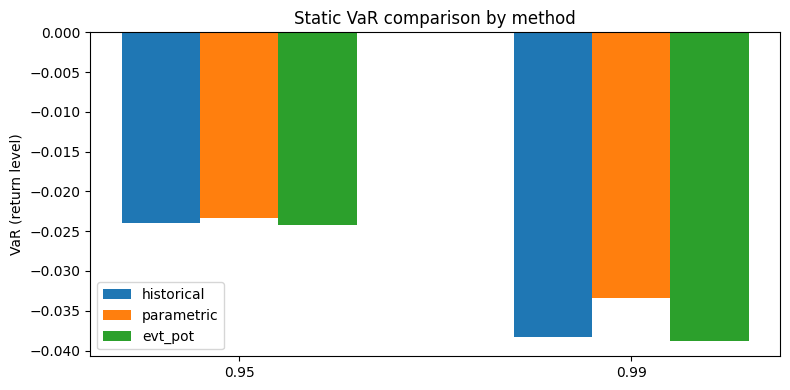

In [77]:
static_compare = {'evt': {}, 'historical': {}, 'parametric_normal': {}}
if os.path.exists(prev_summary_path):
    with open(prev_summary_path, 'r') as f:
        prev = json.load(f)
    for item in prev:
        if item.get('mode') == 'static_fullsample':
            static_compare[item['method']][item['alpha']] = item

print("\nStatic comparisons :")
for alpha in ALPHAS:
    row = {
        'alpha': alpha,
        'evt_var': evt_static.get(alpha, {}).get('var_return'),
        'evt_es': evt_static.get(alpha, {}).get('es_return'),
        'hist_var': static_compare.get('historical', {}).get(alpha, {}).get('est_VaR'),
        'hist_es': static_compare.get('historical', {}).get(alpha, {}).get('est_ES'),
        'param_var': static_compare.get('parametric_normal', {}).get(alpha, {}).get('est_VaR'),
        'param_es': static_compare.get('parametric_normal', {}).get(alpha, {}).get('est_ES')
    }
    print(row)


alph_to_plot = ALPHAS
labels = []
values = {'evt': [], 'hist': [], 'param': []}
for alpha in alph_to_plot:
    labels.append(str(alpha))
    values['evt'].append(evt_static.get(alpha, {}).get('var_return'))
    hist_v = static_compare.get('historical', {}).get(alpha, {}).get('est_VaR')
    param_v = static_compare.get('parametric_normal', {}).get(alpha, {}).get('est_VaR')
    values['hist'].append(hist_v)
    values['param'].append(param_v)

x = np.arange(len(labels))
width = 0.2
plt.figure(figsize=(8,4))
plt.bar(x - width, values['hist'], width=width, label='historical' if any(values['hist']) else None)
plt.bar(x, values['param'], width=width, label='parametric' if any(values['param']) else None)
plt.bar(x + width, values['evt'], width=width, label='evt_pot')
plt.xticks(x, labels)
plt.ylabel('VaR (return level)')
plt.title('Static VaR comparison by method')
plt.legend()
plt.tight_layout()
plt.show()

 на 95%—99% исторический и EVT согласуются

Для стрессовых сценариев  лучше использолвать EVT (GPD) + bootstrap доверительные интервалы, а не нормальную парамертизацию.

Параметрическая нормальная оценка недоверительна к хвостам и даёт слишком оптимистичные VaR/ES, особенно на 99% и выше.

# 6 Шаг
Результаты

In [82]:
!pip install --quiet matplotlib seaborn fpdf

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import norm
from math import sqrt, isnan

os.makedirs('results/figures', exist_ok=True)

pf_path = 'data/portfolio_returns.csv'
summary_csv = 'results/var_es_comparison.csv'
evt_json = 'results/evt_var_es_results.json'
backtest_json = 'results/var_backtest_results.json'

pf = pd.read_csv(pf_path, index_col=0, parse_dates=True)
returns = pf['simple_r'].dropna()
n = len(returns)

summary_df = None
if os.path.exists(summary_csv):
    try:
        summary_df = pd.read_csv(summary_csv)
    except Exception:
        summary_df = None

evt_results = None
if os.path.exists(evt_json):
    try:
        with open(evt_json, 'r') as f:
            evt_results = json.load(f)
    except:
        evt_results = None

def hist_var(series, alpha):
    return series.quantile(1 - alpha)

def hist_es(series, alpha):
    q = hist_var(series, alpha)
    tail = series[series <= q]
    return tail.mean() if len(tail) > 0 else np.nan

def param_var(series, alpha):
    mu = series.mean()
    sigma = series.std(ddof=1)
    z = norm.ppf(1 - alpha)
    return mu + sigma*z

def param_es(series, alpha):
    mu = series.mean()
    sigma = series.std(ddof=1)
    z = norm.ppf(1 - alpha)
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    if Phi == 0:
        return np.nan
    return mu - sigma*(phi / Phi)

alphas = [0.95, 0.99]
def fmt_num(x):
    if x is None:
        return "NA"
    try:
        xv = float(x)
    except Exception:
        return "NA"
    return f"{xv:.4f}"
static_metrics = []
for method in ['historical','parametric_normal']:
    for alpha in alphas:
        if method=='historical':
            v = hist_var(returns, alpha)
            es = hist_es(returns, alpha)
        else:
            v = param_var(returns, alpha)
            es = param_es(returns, alpha)
        static_metrics.append({'method':method,'alpha':alpha,'est_VaR':float(v),'est_ES':float(es)})
static_df = pd.DataFrame(static_metrics)

evt_static = {}
if evt_results is not None:
    try:
        if isinstance(evt_results, list):
            for it in evt_results:
                if it.get('mode') == 'static_fullsample' and it.get('method','').startswith('evt'):
                    evt_static[it['alpha']] = it
        elif isinstance(evt_results, dict):
            evt_static = evt_results
    except Exception:
        evt_static = {}

WINDOW = 252
def rolling_historical_var_series(series, window=252, alpha=0.99):
    dates=[]
    vals=[]
    for i in range(window, len(series)):
        w = series.iloc[i-window:i]
        dates.append(series.index[i])
        vals.append(w.quantile(1-alpha))
    return pd.Series(vals, index=dates)

def rolling_param_var_series(series, window=252, alpha=0.99):
    dates=[]
    vals=[]
    for i in range(window, len(series)):
        w = series.iloc[i-window:i]
        mu = w.mean(); sigma = w.std(ddof=1)
        z = norm.ppf(1-alpha)
        dates.append(series.index[i])
        vals.append(mu + sigma*z)
    return pd.Series(vals, index=dates)

rolling_vars = {}
for alpha in alphas:
    rolling_vars[f'hist_{alpha}'] = rolling_historical_var_series(returns, WINDOW, alpha)
    rolling_vars[f'param_{alpha}'] = rolling_param_var_series(returns, WINDOW, alpha)

figures = []

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(returns, bins=100, kde=True, ax=ax)
colors = {'historical':'tab:blue','parametric_normal':'tab:orange','evt':'tab:green'}
for idx,row in static_df.iterrows():
    m = row['method']; a = row['alpha']; v = row['est_VaR']; es = row['est_ES']
    ax.axvline(v, color=colors.get(m,'k'), linestyle='--', linewidth=1.5, label=f"{m} VaR{int(a*100)}% = {v:.4f}")
if evt_static:
    for a, item in evt_static.items():
        try:
            v = float(item['var_return'] if isinstance(item, dict) and 'var_return' in item else item.get('est_VaR', np.nan))
            ax.axvline(v, color='tab:green', linestyle=':', linewidth=1.5, label=f"EVT VaR{int(float(a)*100)}% = {v:.4f}")
        except:
            pass
ax.set_title('Distribution of portfolio returns (P&L) with VaR estimates')
ax.legend(fontsize=8, loc='upper left')
fig.savefig('results/figures/histogram_var.png', dpi=150, bbox_inches='tight')
figures.append(('Histogram with VaR lines', fig))

lookback = 500
start_date = returns.index[-lookback] if len(returns) > lookback else returns.index[0]
fig, ax = plt.subplots(figsize=(12,5))
returns.loc[start_date:].plot(ax=ax, label='return', alpha=0.8)
for alpha in alphas:
    s_hist = rolling_vars[f'hist_{alpha}'].loc[start_date:] if f'hist_{alpha}' in rolling_vars else None
    s_param = rolling_vars[f'param_{alpha}'].loc[start_date:] if f'param_{alpha}' in rolling_vars else None
    if s_hist is not None and len(s_hist)>0:
        ax.plot(s_hist.index, s_hist.values, label=f'hist VaR {alpha}', linewidth=1.2)
    if s_param is not None and len(s_param)>0:
        ax.plot(s_param.index, s_param.values, label=f'param VaR {alpha}', linewidth=1.0, linestyle='--')
ax.set_title(f'Portfolio returns and rolling VaR (last {lookback} days)')
ax.legend(fontsize=9)
fig.savefig('results/figures/returns_with_rolling_var.png', dpi=150, bbox_inches='tight')
figures.append(('Returns with rolling VaR', fig))

fig, ax = plt.subplots(figsize=(12,4))
if len(rolling_vars['hist_0.99'])>0:
    rolling_vars['hist_0.99'].plot(ax=ax, label='hist VaR 99%')
if len(rolling_vars['param_0.99'])>0:
    rolling_vars['param_0.99'].plot(ax=ax, label='param VaR 99%')
ax.set_title('Rolling VaR series (99%) — historical vs parametric')
ax.legend()
fig.savefig('results/figures/rolling_var_99.png', dpi=150, bbox_inches='tight')
figures.append(('Rolling VaR 99%', fig))

plot_df = static_df.copy()
plot_df['label'] = plot_df['method'] + ' ' + plot_df['alpha'].astype(str)
fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(plot_df))
ax.bar(x - 0.15, plot_df['est_VaR'], width=0.3, label='VaR')
ax.bar(x + 0.15, plot_df['est_ES'], width=0.3, label='ES')
ax.set_xticks(x); ax.set_xticklabels(plot_df['label'], rotation=45, ha='right')
ax.set_title('Static VaR and ES (full-sample)')
ax.legend()
fig.savefig('results/figures/static_var_es_compare.png', dpi=150, bbox_inches='tight')
figures.append(('Static VaR/ES comparison', fig))

table_df = summary_df if summary_df is not None else static_df
tab = table_df.copy().head(50)
fig, ax = plt.subplots(figsize=(10, min(0.5 + 0.25*len(tab), 8)))
ax.axis('off')
tbl = ax.table(cellText=tab.values, colLabels=tab.columns, loc='center', cellLoc='left')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)
ax.set_title('Summary table (first rows)')
fig.savefig('results/figures/summary_table.png', dpi=150, bbox_inches='tight')
figures.append(('Summary table', fig))

summary_out = 'results/summary_table.csv'
if summary_df is None:
    static_df.to_csv(summary_out, index=False)
else:
    summary_df.to_csv(summary_out, index=False)

report_path = 'results/report.pdf'
with PdfPages(report_path) as pdf:
    for title, fig in figures:
        pdf.savefig(fig)
        plt.close(fig)
    fig_text = plt.figure(figsize=(8.27, 11.69))
    txt = []
    txt.append("VaR / CVaR Project — Summary Report")
    txt.append("")
    txt.append(f"Data: portfolio returns, observations = {n}")
    txt.append("")
    for idx,row in static_df.iterrows():
        txt.append(f"{row['method']} @ {row['alpha']*100:.0f}%: VaR={row['est_VaR']:.4f}, ES={row['est_ES']:.4f}")
    if evt_static:
        txt.append("")
        txt.append("EVT (static full-sample):")
        for a,it in evt_static.items():
          v = it.get('var_return') if isinstance(it, dict) else None
          es = it.get('es_return')  if isinstance(it, dict) else None
          txt.append(f" EVT @ {float(a)*100:.0f}%: VaR={fmt_num(v)} ES={fmt_num(es)}")
    txt.append("")
    txt.append("Interpretation / Recommendations:")
    txt.append("- Compare observed exception rates from rolling backtests to expected (1-alpha).")
    txt.append("- EVT gives tail-focused estimates (VaR99 ~ see EVT static). Use with caution when extrapolating.")
    txt.append("- For model-risk: document assumptions, sample length, backtest results, and sensitivity to threshold/window.")
    fig_text.text(0.02, 0.98, "\n".join(txt), va='top', ha='left', fontsize=11, wrap=True)
    pdf.savefig(fig_text)
    plt.close(fig_text)

notes = {
    'report': report_path,
    'figures_folder': 'results/figures',
    'summary_csv': summary_out,
    'how_to_run': [
        'Run earlier steps 1-5 to compute returns, VaR/ES and EVT.',
        'Then run this visualization cell to build figures and results/report.pdf.'
    ],
    'interpretation': [
        'Check rolling exception rates vs expected 1-alpha.',
        'If Kupiec p-value small -> model miscalibrated.',
        'EVT requires enough exceedances to fit GPD reliably.'
    ]
}
with open('results/report_notes.txt','w') as f:
    json.dump(notes, f, indent=2, ensure_ascii=False)

print("Saved PDF report ->", report_path)
print("Saved figure files to results/figures/")



/tmp/ipython-input-1570333213.py:145: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(s_hist.index, s_hist.values, label=f'hist VaR {alpha}', linewidth=1.2)


Saved PDF report -> results/report.pdf
Saved figure files to results/figures/
